In [132]:
import yfinance as yf
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

In [2]:
GetFacebookInformation = yf.Ticker("META")
print(GetFacebookInformation.history(period="max"))


                                 Open        High         Low       Close  \
Date                                                                        
2012-05-18 00:00:00-04:00   42.049999   45.000000   38.000000   38.230000   
2012-05-21 00:00:00-04:00   36.529999   36.660000   33.000000   34.029999   
2012-05-22 00:00:00-04:00   32.610001   33.590000   30.940001   31.000000   
2012-05-23 00:00:00-04:00   31.370001   32.500000   31.360001   32.000000   
2012-05-24 00:00:00-04:00   32.950001   33.209999   31.770000   33.029999   
...                               ...         ...         ...         ...   
2024-02-12 00:00:00-05:00  468.190002  479.149994  466.579987  468.899994   
2024-02-13 00:00:00-05:00  456.869995  467.890015  455.089996  460.119995   
2024-02-14 00:00:00-05:00  467.929993  474.109985  466.089996  473.279999   
2024-02-15 00:00:00-05:00  475.279999  488.619995  472.220001  484.029999   
2024-02-16 00:00:00-05:00  478.109985  478.959991  469.209991  473.320007   

In [213]:
one_month = GetFacebookInformation.history(period='max')
one_month_train = one_month.iloc[:300] 
one_month_eval = one_month.iloc[2800:]
print(len(one_month_eval))

157


In [214]:
#Evaluate dataset

x_eval = []
y_eval = []

for i in range(1,len(one_month_eval) -1):
    res = []
    res.append(one_month_train.iloc[i-1,[0,1,2,3,4]].tolist())
    res.append(one_month_train.iloc[i,[0,1,2,3,4]].tolist())
    x_eval.append(res)
    y_eval.append(one_month_train.iat[i+1,1])

xx_eval = torch.tensor(x_eval, dtype=torch.float32)
yy_eval = torch.tensor(y_eval, dtype=torch.float32)

tt_eval = (xx_eval, yy_eval)


In [215]:
xx = []
yy = []

for i in range(1,len(one_month_train) -1):
    res = []
    res.append(one_month_train.iloc[i-1,[0,1,2,3,4]].tolist())
    res.append(one_month_train.iloc[i,[0,1,2,3,4]].tolist())
    xx.append(res)
    yy.append(one_month_train.iat[i+1,1])

xx_train = torch.tensor(xx, dtype=torch.float32)
yy_train = torch.tensor(yy, dtype=torch.float32)

tt_train = (xx_train, yy_train)



In [216]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self,src):
        src = self.transformer_encoder(src)
        output = self.fc(src[-1])  # Get the output from the last time step
        return output

In [225]:
#VARIABLES
input_dim = 5  # Dimensionality of input features
output_dim = 1   # Dimensionality of output (e.g., predicted price change)
num_layers = 4   # Number of Transformer encoder layers
hidden_dim = 256 # Hidden dimension of feed-forward layers
num_heads = 5    # Number of attention heads
dropout = 0.1    # Dropout probability

num_epochs = 10

In [226]:
model = TransformerModel(input_dim, output_dim, num_layers, hidden_dim, num_heads, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [227]:
losses = []
print(len(tt_train[1]))

for epoch in range(num_epochs):
    model.train()
    for x in range(len(tt_train[1])):
        inputs = tt_train[0][x]
     
        targets = torch.tensor(tt_train[1][x])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    losses.append(loss.item())

298


C:\Users\Hampus\AppData\Local\Temp\ipykernel_4832\2507591663.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(tt_train[1][x])


Epoch 1/10, Loss: 1175.8240966796875
Epoch 2/10, Loss: 789.7499389648438
Epoch 3/10, Loss: 441.9554138183594
Epoch 4/10, Loss: 243.6337127685547
Epoch 5/10, Loss: 158.7877960205078
Epoch 6/10, Loss: 132.80746459960938
Epoch 7/10, Loss: 129.02581787109375
Epoch 8/10, Loss: 136.9346923828125
Epoch 9/10, Loss: 123.48954772949219
Epoch 10/10, Loss: 132.83018493652344


In [233]:
#EVALUATE
outputs_eval = []
expected_outputs = y_eval
model.eval()
for x in range(len(tt_eval[1])):
    inputs = tt_eval[0][x]
    #targets = torch.tensor(tt_eval[1][x])
    outputs = model(inputs)
    print(outputs[0])
    outputs_eval.append(outputs)


tensor(26.6452, grad_fn=<SelectBackward0>)
tensor(26.6455, grad_fn=<SelectBackward0>)
tensor(26.6455, grad_fn=<SelectBackward0>)
tensor(26.6455, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6455, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6453, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6453, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6455, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6455, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6455, grad_fn=<SelectBackward0>)
tensor(26.6454, grad_fn=<SelectBackward0>)
tensor(26.6456, grad_fn=<SelectBackward0>)
tensor(26.6

IndexError: list index out of range

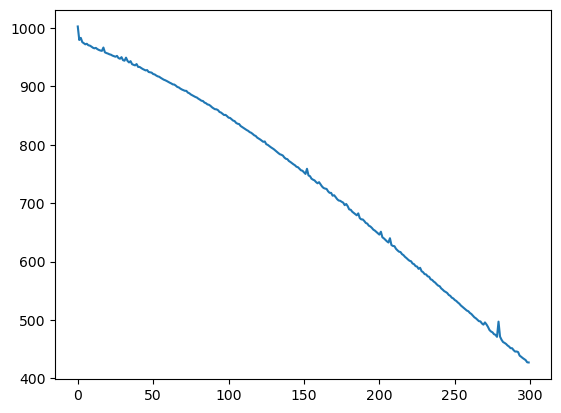

In [202]:
##TRAIN LOSS
import matplotlib.pyplot as plt

plt.plot(losses)
print(losses[2700])

[tensor([26.6452], grad_fn=<AddBackward0>), tensor([26.6455], grad_fn=<AddBackward0>), tensor([26.6455], grad_fn=<AddBackward0>), tensor([26.6455], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6455], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6453], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6453], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6455], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6455], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26.6455], grad_fn=<AddBackward0>), tensor([26.6454], grad_fn=<AddBackward0>), tensor([26.6456], grad_fn=<AddBackward0>), tensor([26

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

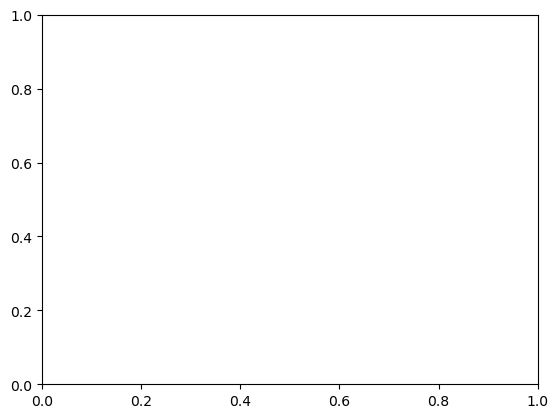

In [234]:
##EVAL
print(outputs_eval)
plt.plot(outputs_eval)
plt.plot(expected_outputs)